# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### Import packages

In [6]:
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import pytz


### Setup Actor Critic Model


In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size* num_agents, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+(action_size*num_agents), fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Setup Agents

In [8]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            num_agents (int): number of agents
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.eps = eps_start
        self.t_step = 0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
                
        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done, agent_number):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.t_step += 1
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
    
        # Learn, if enough samples are available in memory and at interval settings
        if len(self.memory) > BATCH_SIZE:
            if self.t_step % UPDATE_EVERY == 0:
                for _ in range(N_UPDATES):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA, agent_number)

    def act(self, states, add_noise):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        if add_noise:
            actions += self.eps * self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, agent_number):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        
        if agent_number == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
            
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        
        if agent_number == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)

        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

        # Update epsilon noise value
        self.eps = self.eps - (1/eps_decay)
        if self.eps < eps_end:
            self.eps=eps_end
                  
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
            
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.13, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Training kickstart

In [16]:
BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e6)  # replay buffer size
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
TAU = 6e-2              # for soft update of target parameters
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 1        # time steps between network updates
N_UPDATES = 1           # number of times training
ADD_NOISE = True

eps_start = 6           # Noise level start
eps_end = 0             # Noise level end
eps_decay = 250         # Number of episodes to decay over from start to end

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

""" Setup two independent agents with shared experience memory """
agent_0 = Agent(state_size, action_size, 1, random_seed=0)
agent_1 = Agent(state_size, action_size, 1, random_seed=0)

In [18]:
print ("***STARTED TRAINING AT {} ".format(datetime.datetime.now().astimezone().isoformat(timespec='minutes')))

n_episodes = 5000
scores_window = deque(maxlen=100)
scores_all = []
rolling_average = []

for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    states = np.reshape(states, (1,48))
    agent_0.reset()
    agent_1.reset()
    scores = np.zeros(num_agents)
    while True:
        action_0 = agent_0.act(states, ADD_NOISE)           # agent 1 chooses an action
        action_1 = agent_1.act(states, ADD_NOISE)           # agent 2 chooses an action
        actions = np.concatenate((action_0, action_1), axis=0) 
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
        next_states = env_info.vector_observations         # get next states
        next_states = np.reshape(next_states, (1, 48))     # combine each agent's state into one state space
        rewards = env_info.rewards                         # get reward
        done = env_info.local_done                         # see if episode finished

        agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
        agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
        scores += rewards                                  # update the score for each agent
        states = next_states                               # roll over states to next time step

        if np.any(done):                                  # exit loop if episode finished
            break

    scores_window.append(np.max(scores))
    scores_all.append(np.max(scores))
    rolling_average.append(np.mean(scores_window))
                
    if i_episode % 20 == 0:
        print('Episode {}\tMax Reward: {:.3f}\tAverage Reward: {:.3f}'.format(
            i_episode, np.max(scores), np.mean(scores_window)))

    if np.mean(scores_window)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
            i_episode-100, np.mean(scores_window)))
        torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
        torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
        torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
        torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
        break
print ("***FINISHED TRAINING AT {} ".format(datetime.datetime.now().astimezone().isoformat(timespec='minutes')))

***STARTED TRAINING AT 2019-03-30T20:18+08:00 
Episode 20	Max Reward: 0.000	Average Reward: 0.010
Episode 40	Max Reward: 0.000	Average Reward: 0.015
Episode 60	Max Reward: 0.100	Average Reward: 0.016
Episode 80	Max Reward: 0.000	Average Reward: 0.012
Episode 100	Max Reward: 0.100	Average Reward: 0.014
Episode 120	Max Reward: 0.000	Average Reward: 0.015
Episode 140	Max Reward: 0.090	Average Reward: 0.020
Episode 160	Max Reward: 0.100	Average Reward: 0.026
Episode 180	Max Reward: 0.100	Average Reward: 0.036
Episode 200	Max Reward: 0.000	Average Reward: 0.041
Episode 220	Max Reward: 0.100	Average Reward: 0.047
Episode 240	Max Reward: 0.000	Average Reward: 0.048
Episode 260	Max Reward: 0.100	Average Reward: 0.050
Episode 280	Max Reward: 0.090	Average Reward: 0.052
Episode 300	Max Reward: 0.090	Average Reward: 0.060
Episode 320	Max Reward: 0.000	Average Reward: 0.064
Episode 340	Max Reward: 0.090	Average Reward: 0.074
Episode 360	Max Reward: 0.000	Average Reward: 0.078
Episode 380	Max Rewar

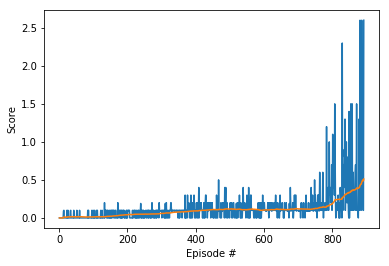

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)
plt.plot(np.arange(1, len(rolling_average)+1), rolling_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [25]:
# Load the saved training parameters
agent_0.actor_local.load_state_dict(torch.load('checkpoint_actor_0.pth', map_location='cpu'))
agent_0.critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth', map_location='cpu'))
agent_1.actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth', map_location='cpu'))
agent_1.critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth', map_location='cpu'))

# Set environment to evalulation mode
env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
states = np.reshape(states, (1,48))

for i in range(200):
    action_0 = agent_0.act(states, add_noise=False)         
    action_1 = agent_1.act(states, add_noise=False)        
    actions = np.concatenate((action_0, action_1), axis=0) 
    actions = np.reshape(actions, (1, 4))
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    next_states = np.reshape(next_states, (1, 48))
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    states = next_states                              
    if np.any(dones):                              
        break

### New heading

https://youtu.be/ifiFtrm_KHU

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```